In [1]:
import sys
sys.path.append("..")

import bpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
import seaborn as sns

from framework.utils import *

np.random.seed(42)

In [2]:
%matplotlib inline

# Testing player level code

In [3]:
model = pystan.StanModel(file="player_forecasts.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c4b3dae224ed40cd55af0e4da27a5f1 NOW.


In [4]:
# numbers of players and matches
n_player = 500
n_match = 30

# goals scored by team
goals = np.random.poisson(lam=2.0, size=(n_player, n_match))

# player level parameters
theta = np.random.dirichlet(np.ones(3), size=n_player)

# minutes played
minutes = np.clip(
    np.random.normal(loc=60., scale=10., size=(n_player, n_match)),
    0.0,
    90.0
)

# augmented scoring probabilities
theta_aug = np.array([
    [theta[i, 0]*(minutes[i, j] / 90.0), 
     theta[i, 1]*(minutes[i, j] / 90.0),
     theta[i, 2]*(minutes[i, j] / 90.0) + (90.0 - minutes[i, j]) / 90.0]
    for i in range(n_player)
    for j in range(n_match)
]).reshape(n_player, n_match, 3)

# results for the player
y = np.array([
    np.random.multinomial(goals[i, j], theta_aug[i, j])
    for i in range(n_player)
    for j in range(n_match)
]).reshape(n_player, n_match, 3)

In [5]:
stan_data = dict(
    nplayer=n_player,
    nmatch=n_match,
    minutes=minutes,
    y=y,
    alpha=[1, 1, 1]
)

In [6]:
fit = model.optimizing(stan_data)

## Test on real data

### 1. Fit the team level model

In [ ]:
df_past = pd.DataFrame(np.array([[s.date, s.home_team, s.away_team, s.home_score, s.away_score]
                        for s in session.query(Match).all()]),
             columns=["date", "home_team", "away_team", "home_goals", "away_goals"])
df_past["home_goals"] = df_past["home_goals"].astype(int)
df_past["away_goals"] = df_past["away_goals"].astype(int)
df_past["date"] = pd.to_datetime(df_past["date"])
df_past = df_past[df_past["date"] > "2016-08-01"]

In [ ]:
model_team = bpl.BPLModel(df_past)
model_team.fit()

## 2. Fit player level model

In [8]:
def get_empirical_bayes_estimates(df_emp):
    # still not sure about this...
    df = df_emp.copy()
    df = df[df["match_id"] != 0]
    goals = df["goals"].sum()
    assists = df["assists"].sum()
    neither = df["neither"].sum()
    minutes = df["minutes"].sum()
    team = df["team_goals"].sum()
    total_minutes = 90*len(df)
    neff = df.groupby("player_name").count()["goals"].mean()
    a0 = neff * (goals / team) * (total_minutes / minutes)
    a1 = neff *(assists / team) * (total_minutes / minutes)
    a2 = neff *((neither / team) - (total_minutes - minutes) / total_minutes) * (total_minutes / minutes)
    alpha = np.array([a0, a1, a2])
    return alpha

def process_player_data(prefix):
    df = pd.read_csv("../data/player_history_{}.csv".format(prefix))
    df["neither"] = df["team_goals"] - df["goals"] - df["assists"]
    alpha = get_empirical_bayes_estimates(df)
    y = df.sort_values("player_name")[
        ["goals", "assists", "neither"]
    ].values.reshape((df["player_name"].nunique(),
                      df.groupby("player_name").count().iloc[0]["player_id"],
                      3))

    minutes = df.sort_values("player_name")[
        "minutes"
    ].values.reshape((df["player_name"].nunique(),
                      df.groupby("player_name").count().iloc[0]["player_id"]))

    nplayer = df["player_name"].nunique()
    nmatch = df.groupby("player_name").count().iloc[0]["player_id"]
    player_names = np.sort(df["player_name"].unique())
    return dict(
        nplayer=nplayer, 
        nmatch=nmatch,
        minutes=minutes,
        y=y,
        alpha=alpha
    ), player_names

def fit_data(prefix, model):
    data, names = process_player_data(prefix)
    fit = model.optimizing(data)
    df = pd.DataFrame(
        fit["theta"],
        columns=["pr_score", "pr_assist", "pr_neither"]
    ).set_index(names).reset_index()
    df["pos"] = prefix
    return df, fit, data

def fit_all_data(model):
    df = pd.DataFrame()
    fits = []
    dfs = []
    reals = []
    for prefix in ["FWD", "MID", "DEF"]:
        d, f, r  = fit_data(prefix, model)
        fits.append(f)
        dfs.append(d)
        reals.append(r)
    df = pd.concat(dfs).rename(
        columns={"index": "player_name"}
    ).sort_values("player_name").set_index("player_name")
    return df, fits, reals

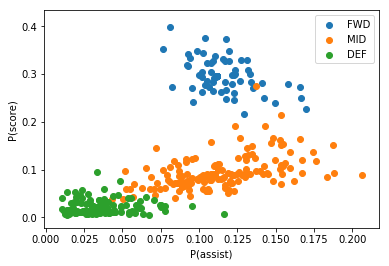

In [9]:
df_stat, fits, reals = fit_all_data(model)
for pos in ["FWD", "MID", "DEF"]:
    plt.scatter(
        df_stat.loc[df_stat["pos"] == pos ,"pr_assist"],
        df_stat.loc[df_stat["pos"] == pos ,"pr_score"],
        label=pos
    )
plt.xlabel("P(assist)")
plt.ylabel("P(score)")
plt.legend();

## 3. distribution of playing times

In [10]:
df = pd.concat(
    [pd.read_csv("../data/player_history_{}.csv".format(prefix)) for prefix in ["DEF", "MID", "FWD"]]
)
df = df[df["match_id"] != 0]

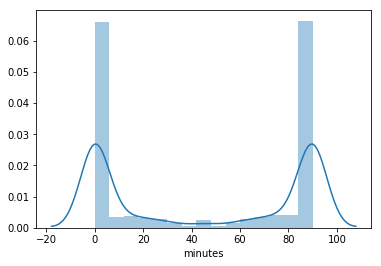

In [11]:
sns.distplot(df["minutes"]);

Model the probability that players will play in chunks: $t = 0$, $0 < t < 45$, $45 < t < 90$, $t = 90$?

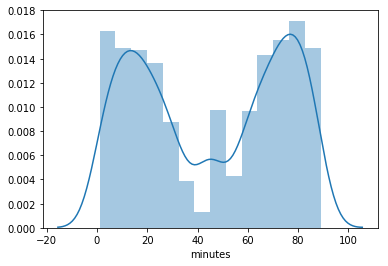

In [12]:
mins = df["minutes"]
sns.distplot(mins[(mins != 0)&(mins != 90)]);

An issue might be that a player goes through patches of player no time at all (i.e., injury) and patches where they play a lot. 

Perhaps a way to gain an approximate sample of $p(T)$ could be to simply take the player's last $N$ matches and then assume these are i.i.d from $p(T)$ and sum over these.

Furthermore, if a player is red (i.e., injured) on the website, we should set $p(T) = 0$ if $T \neq 0$.

## 4. Putting it all together

We will evaluate the expected number of goals / assists for a player by ($p$ denotes a density and $\mathrm{Pr}$ denotes a probability):

$$
\begin{aligned}
\mathrm{Pr}(n_g, n_a, n_n) &= \int \mathrm{d}T \sum\limits_{N_g = 0}^\infty \mathrm{Pr}(n_g, n_a, n_n | N_g, T)\,\mathrm{Pr}(N_g)\,p(T) \\
     &\simeq \dfrac{1}{M}\sum_\limits{i=1}^M \sum\limits_{N_g=0}^{15} \mathrm{Pr}(n_g, n_a, n_n | N_g, T_i)\,\mathrm{Pr}(N_g)
\end{aligned}
$$

Where $T_i$ are the amount of time that a player has spent on the pitch in their past $M$ matches, $N_g$ are the number of goals scored by their team, and $n_g, n_a, n_n$ is the number of goals, assists and goals where the player is not involved.

$p(N_g)$ is obtained from the team-level model. $p(n_g, n_a, n_n | N_g, T_i)$ is obtained from the multinomial model above.

For clean sheets, the calculation is much easier: one simply evaluates $p(N_c = 0)\times p(T > 60)$ using the team-level model, where $N_c$ is the number of goals a team concedes.

Once we have $p(X)$ and $p(N_c = 0)$ , we can compute the expected values of $(n_g, n_a, n_n)$ and multiply by the number of points the player gets for the outcomes. Then, we sum it all up and get the expected points!